<a href="https://colab.research.google.com/github/100479095/Predictor_F1_2025/blob/main/entrenamiento_modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**INTRODUCCIÓN**

---

En este notebook se muestra el entrenamiento de varios modelos de IA para predecir las posiciones del último Gran Premio de Fórmula 1 de 2025, Abu Dabi. Para ello se realizó previamente un  preprocesado de los datos, recopilados de kaggle, lo cuáles se pueden encontrar en el fichero "f1_trainning_data_2014_onwards.csv". En este notebook se eliminarán algunas columnas de este csv con el objetivo de tener un dataset genérico y realizará una validación cruzada entre distintos modelos para encontrar el mejor, el cuál será utilizado para predecir los resultados finales del GP.


#**Carga de datos**

---

Primero que todo importamos las distintas librerias que estaremos utilizando a lo largo del entrenamiento y la validación cruzada.

In [1]:
#Importamos las librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

Cargamos los datos del **csv f1_training_data_2014_onwards.csv**, es importante recordar que este fichero es **generado por el script de carga de python** y para lograr que el código se ejecute de manera correcta hay que **subirlo a la plataforma de google colab**.

In [2]:
df = pd.read_csv('f1_training_data_2014_onwards.csv')
#mostramos las primeras 5 filas
print(df.head())

   RACEID  DRIVERID  CONSTRUCTORID  CIRCUITID  ROUND  YEAR  LAP DISTANCE KM  \
0     900         1            131          1      1   -11            5.278   
1     900         3            131          1      1   -11            5.278   
2     900         4              6          1      1   -11            5.278   
3     900         8              6          1      1   -11            5.278   
4     900        13              3          1      1   -11            5.278   

   LAPS RACE  URBAN  AVG WIND SPEED  ...        Q2        Q3   BEST Q  GRID  \
0         57      0           26.75  ...  102890.0  104231.0  91699.0     1   
1         57      0           26.75  ...  102264.0  104595.0  92564.0     3   
2         57      0           26.75  ...  102805.0  105819.0  91388.0     5   
3         57      0           26.75  ...  104494.0  300000.0  92439.0    11   
4         57      0           26.75  ...  104242.0  108079.0  91228.0     9   

   Q1 VALID  Q2 VALID  Q3 VALID  RACE VALID  SPRIN

## Matriz de Correlación

Vamos a visualizar la matriz de correlación de las características numéricas para entender las relaciones entre ellas.

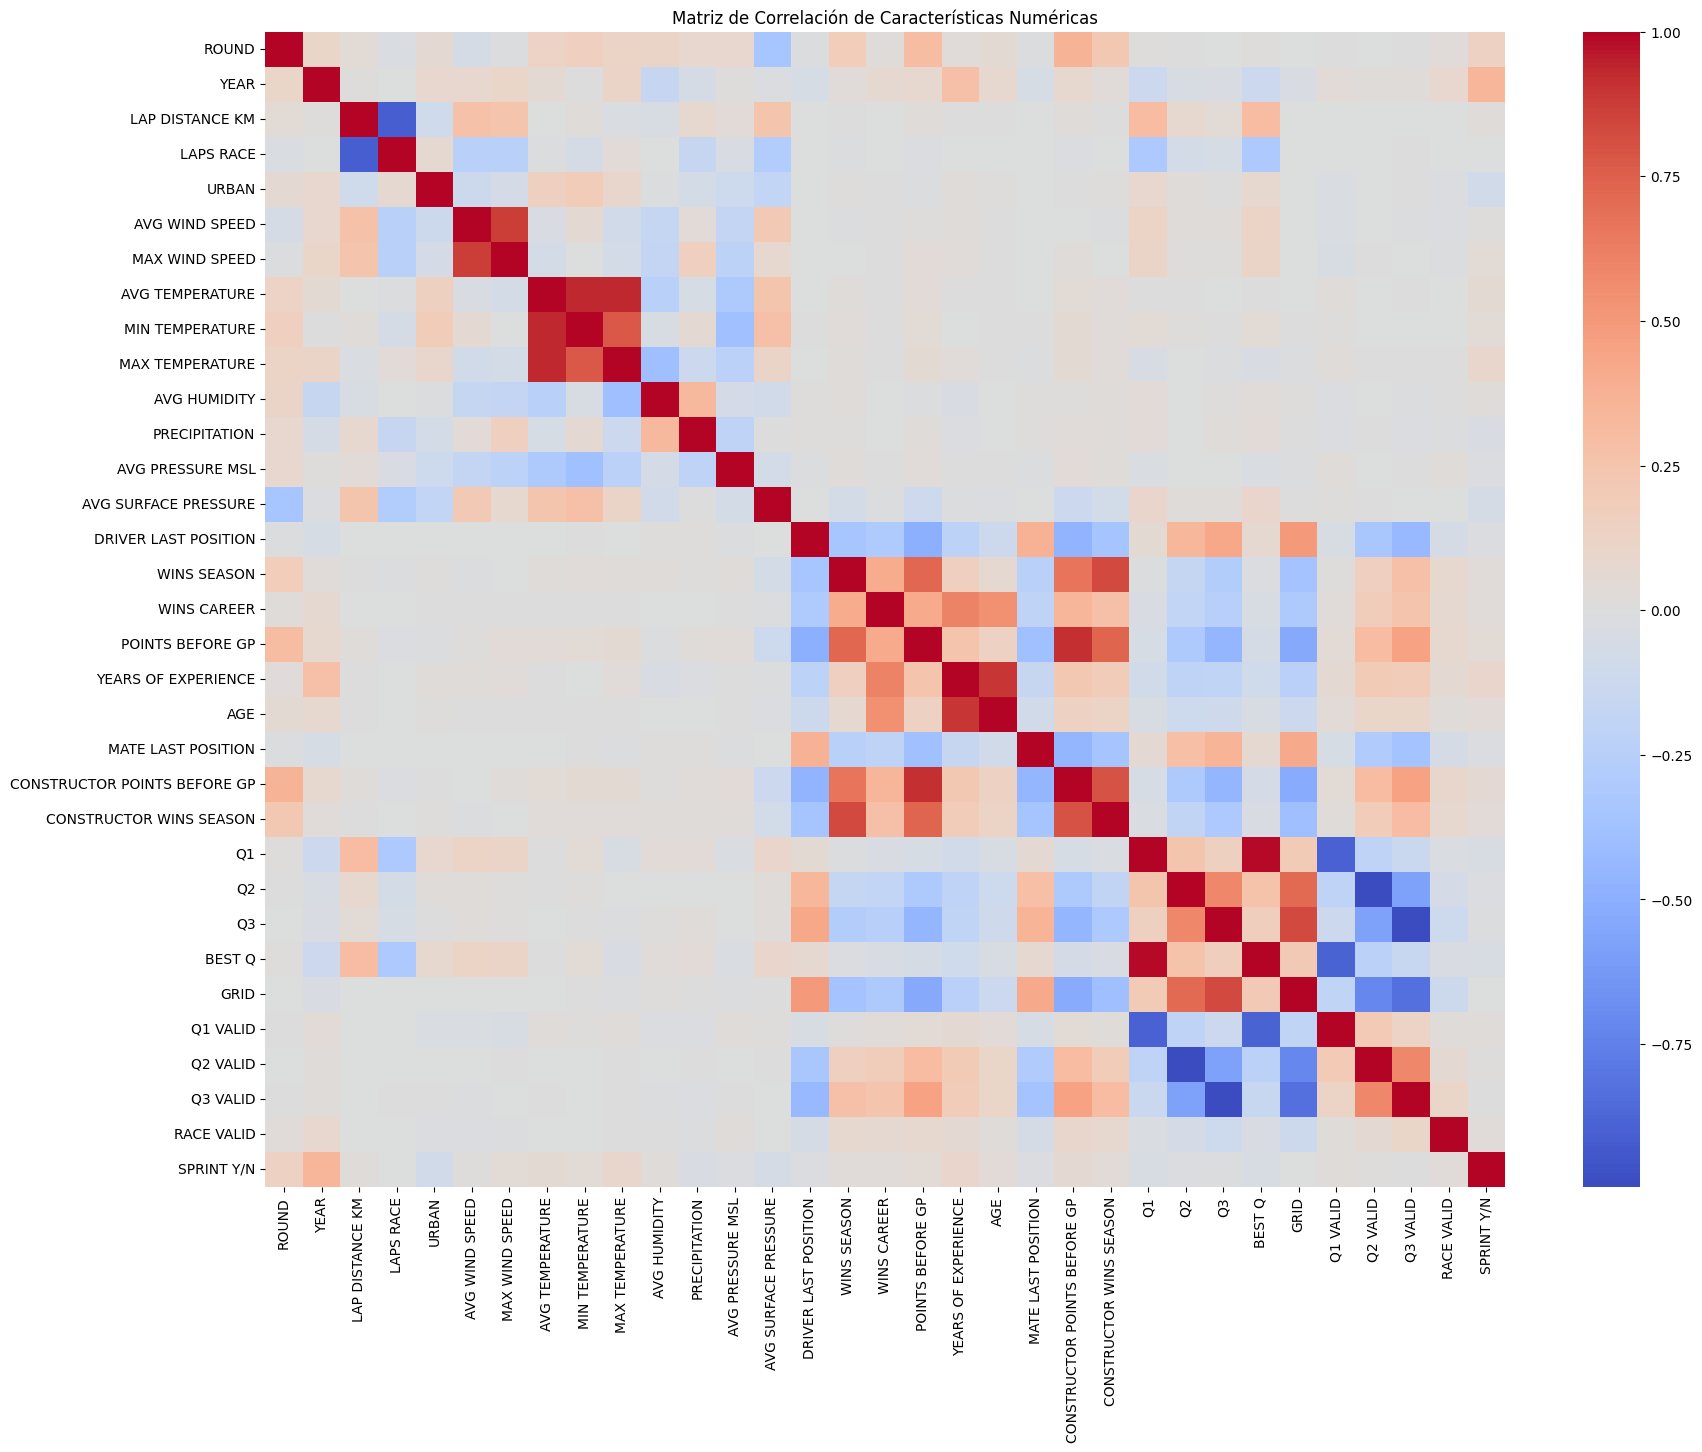

In [4]:
# Calculamos la matriz de correlación para las columnas numéricas del DataFrame completo
# Excluímos las columnas con IDs que no tienen un significado numérico de correlación directa
# y 'MS RACE' que es la variable objetivo.

numerical_df = df.drop(columns=['RACEID', 'DRIVERID', 'CONSTRUCTORID', 'CIRCUITID', 'MS RACE'], errors='ignore')
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Características Numéricas')
plt.show()

In [5]:
# Eliminamos las columnas de temperatura máxima y mínima porque están muy correladas con la temperatura media porque están muy correladas con la temperatura media
# Esto ayuda a evitar multicolinealidad y redundancia en el modelo el modelo
df = df.drop(columns=['MAX TEMPERATURE', 'MIN TEMPERATURE'], errors='ignore')

# Verificamos las columnas restantes
print("Columnas después de eliminar temperatura máxima y mínima:")
print(df.columns.tolist())
print(f"\nNúmero de registros: {len(df)}")
print(f"Número de columnas: {len(df.columns)}")
print(f"Número de columnas: {len(df.columns)}")

Columnas después de eliminar temperatura máxima y mínima:
['RACEID', 'DRIVERID', 'CONSTRUCTORID', 'CIRCUITID', 'ROUND', 'YEAR', 'LAP DISTANCE KM', 'LAPS RACE', 'URBAN', 'AVG WIND SPEED', 'MAX WIND SPEED', 'AVG TEMPERATURE', 'AVG HUMIDITY', 'PRECIPITATION', 'AVG PRESSURE MSL', 'AVG SURFACE PRESSURE', 'DRIVER LAST POSITION', 'WINS SEASON', 'WINS CAREER', 'POINTS BEFORE GP', 'YEARS OF EXPERIENCE', 'AGE', 'MATE LAST POSITION', 'CONSTRUCTOR POINTS BEFORE GP', 'CONSTRUCTOR WINS SEASON', 'Q1', 'Q2', 'Q3', 'BEST Q', 'GRID', 'Q1 VALID', 'Q2 VALID', 'Q3 VALID', 'RACE VALID', 'SPRINT Y/N', 'MS RACE']

Número de registros: 5085
Número de columnas: 36
Número de columnas: 36


## Limpieza y Escalado de Datos

En este apartadp eliminamos las columnas de RACEID y DRIVERID ya que son únicas o muy específicas y queremos que nuestro modelo sea capaz de generalizar entre los datos.

In [6]:
# 1. Asegurar que el DataFrame está ordenado cronológicamente
df = df.sort_values(by=['YEAR', 'ROUND'])

# 2. Definir el corte.
#Escogemos el año 2024 para tener las carreras a partir de este año como test
ultimo_anio = df['YEAR'].max() -1

train_data = df[df['YEAR'] < ultimo_anio]
test_data = df[df['YEAR'] >= ultimo_anio]

#, 'CONSTRUCTORID', 'CIRCUITID'
cols_to_drop = ['RACEID', 'DRIVERID', 'MS RACE', 'CONSTRUCTORID', 'CIRCUITID']
# Transformación Logarítmica de los ms
X_train = train_data.drop(columns=cols_to_drop)
y_train = np.log1p(train_data['MS RACE'])
#test
X_test = test_data.drop(columns=cols_to_drop)
y_test = np.log1p(test_data['MS RACE'])

print(f"Entrenando con {len(X_train)} registros (años anteriores)")
print(f"Testeando con {len(X_test)} registros (año más reciente)")

#Diferenciamos los atributos categoricos de los numericos
categorical_features = []
numerical_features = [col for col in X_train.columns if col not in categorical_features]

#Creamos el pipeline de transformación
preprocessor = ColumnTransformer(
    transformers=[
        # Escalar numéricas para que el modelo no se sesgue por magnitudes grandes
        ('num', StandardScaler(), numerical_features),
        # Convertir IDs a vectores binarios (One-Hot)
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


Entrenando con 4147 registros (años anteriores)
Testeando con 938 registros (año más reciente)


## Definición y Evaluación de Modelos de Regresión

---

Para lograr la regresión vamos a seleccionar el mejor entre 3 modelos (Random Forest, MLP o GradientBoost)



Evaluamos los modelos por validación cruzada:
RandomForestRegressor: 0.2504 (+/- 0.1826)

MLPRegressor: 0.5394 (+/- 0.2466)

GradientBoostingRegressor: 0.2329 (+/- 0.1657)



/tmp/ipython-input-180179377.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels=names, showmeans=True)


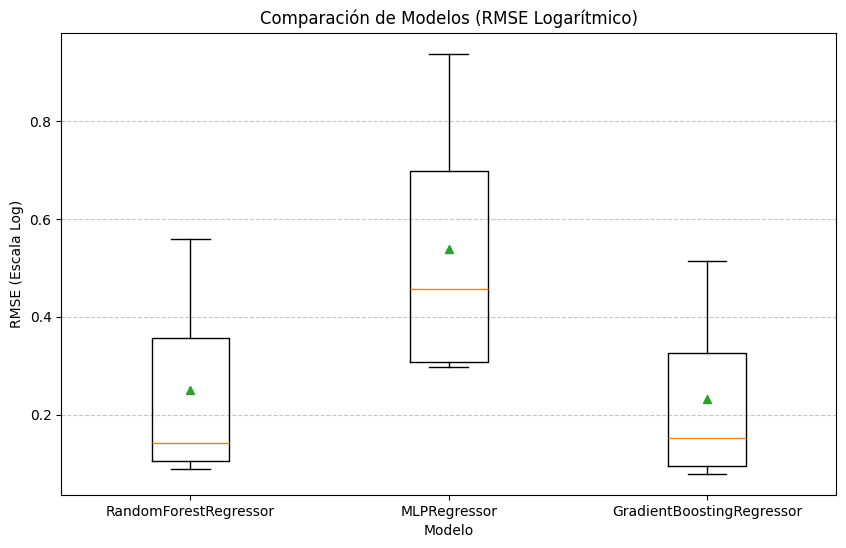

In [7]:
#Modelos a evaluar
models = [
    ('RandomForestRegressor', RandomForestRegressor(n_estimators=50, random_state=42)),
    ('MLPRegressor', MLPRegressor(max_iter=500, random_state=42)),
    ('GradientBoostingRegressor', GradientBoostingRegressor(random_state=42))
]

#Comenzamos el Kfold y la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)
print("\nEvaluamos los modelos por validación cruzada:")
results = []
names = []

for name, model in models:
    #Creamos un pipeline individual para cada modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    #cross_val_score devuelve 'neg_mean_squared_error'por lo que lo negamos y sacamos raíz
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse_scores = np.sqrt(-cv_scores)

    results.append(rmse_scores)
    names.append(name)
    print(f"{name}: {rmse_scores.mean():.4f} (+/- {rmse_scores.std():.4f})")
    print()

#Configuración del tamaño del gráfico
plt.figure(figsize=(10, 6))

#Crear el diagrama de caja (boxplot) usando tus variables 'results' y 'names'
plt.boxplot(results, labels=names, showmeans=True)

#Añadir títulos y etiquetas
plt.title('Comparación de Modelos (RMSE Logarítmico)')
plt.ylabel('RMSE (Escala Log)')
plt.xlabel('Modelo')
plt.grid(axis='y', linestyle='--', alpha=0.7)

#Mostrar el gráfico
plt.show()

## Optimización de Hiperparámetros



In [8]:
#Escogemos el mejor modelo del apartado anterior, en nuestro caso GradientBoostingRegressor
best_model_name = 'GradientBoostingRegressor'
best_model = None
for name, model in models:
    if name == best_model_name:
        best_model = model
        break
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', best_model)])
#Definimos los parámetros para el GridSearch
param_grid = {
    #[100, 200, 300]
    'model__n_estimators': [100, 200, 300],
    #[0.01, 0.05, 0.1]
    'model__learning_rate': [0.01, 0.05, 0.1],
    #[3, 4, 5]
    'model__max_depth': [3, 4, 5]
}

#Inicializamos el Grid Search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=kf,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

#Realizamos el Grid Search
grid_search.fit(X_train, y_train)


#Imprimimos resultados
print(f"\nLos mejores parametros para {best_model_name} son: {grid_search.best_params_}")
print(f"El mejor score de la validación cruzada (neg_mean_squared_error) para {best_model_name} fue: {grid_search.best_score_:.4f}")
print(f"El mejor RMSE para {best_model_name} fue: {np.sqrt(np.abs(grid_search.best_score_)):.4f}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits

Los mejores parametros para GradientBoostingRegressor son: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 300}
El mejor score de la validación cruzada (neg_mean_squared_error) para GradientBoostingRegressor fue: -0.0002
El mejor RMSE para GradientBoostingRegressor fue: 0.0128


## Entrenamiento del Modelo Final y Predicción




In [9]:

#Escogemos el mejor modelo de la validación cruzada
best_model_final = grid_search.best_estimator_

#Predecimos el resultado y lo regresamos a la escala original (ms)
y_pred_log = best_model_final.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test)

#Métricas de evaluación
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print(f"RMSE (en ms): {rmse:,.0f}")
print(f"MAPE (Error Porcentual): {mape:.2%}")
print(f"R-squared (R2): {r2:.4f}")


RMSE (en ms): 717,164
MAPE (Error Porcentual): 9.36%
R-squared (R2): 0.7952


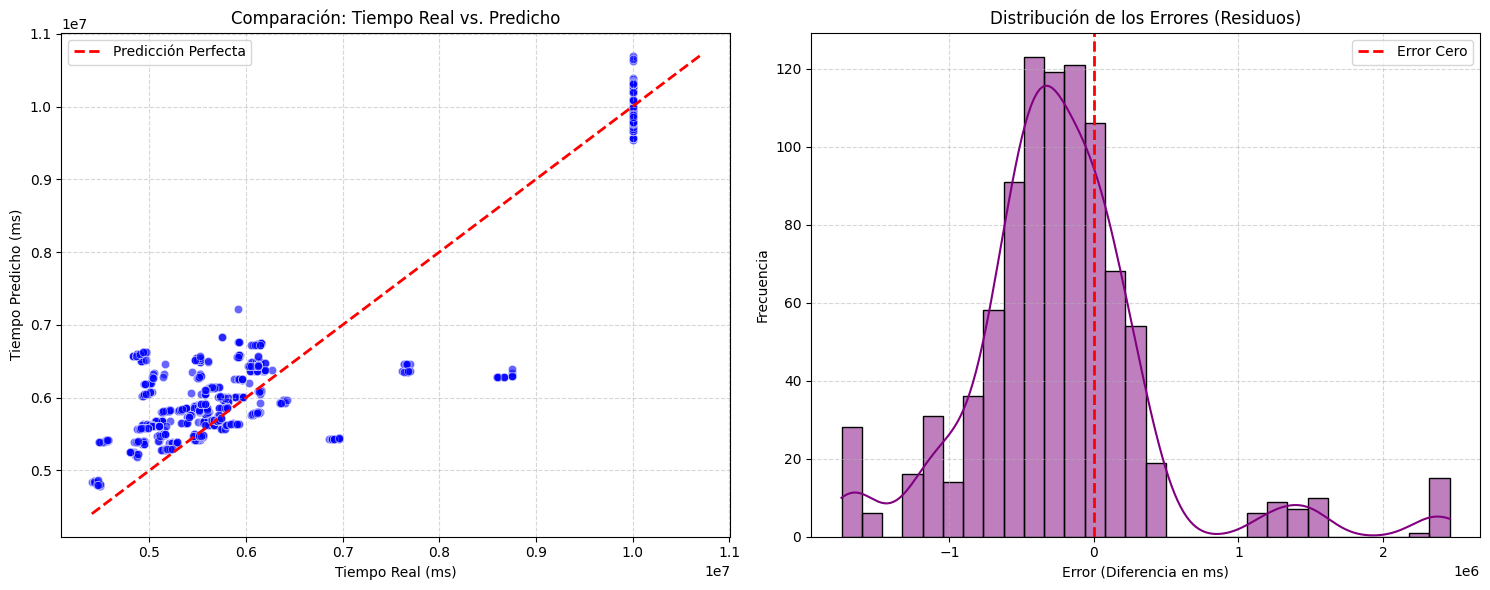

In [ ]:
# Calculamos los residuos (diferencia entre lo real y lo predicho)
residuals = y_test - y_pred

# Configuración de los gráficos
plt.figure(figsize=(15, 6))

# GRÁFICO 1: Dispersión (Scatter Plot) - Real vs Predicho
plt.subplot(1, 2, 1)
# Dibujamos los puntos
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='blue')

# Dibujamos la línea de "Predicción Perfecta" (y = x)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predicción Perfecta')

plt.title('Comparación: Tiempo Real vs. Predicho')
plt.xlabel('Tiempo Real (ms)')
plt.ylabel('Tiempo Predicho (ms)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)


# GRÁFICO 2: Distribución de Errores (Histograma de Residuos)
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, color='purple', bins=30)
plt.axvline(x=0, color='red', linestyle='--', lw=2, label='Error Cero')

plt.title('Distribución de los Errores (Residuos)')
plt.xlabel('Error (Diferencia en ms)')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [ ]:
gp_data = pd.read_csv('f1_race_1168_data.csv')
print(gp_data.head())

   RACEID  DRIVERID  CONSTRUCTORID  CIRCUITID  ROUND  YEAR  LAP DISTANCE KM  \
0    1168       830              9         24     24     0            5.281   
1    1168       846              1         24     24     0            5.281   
2    1168       857              1         24     24     0            5.281   
3    1168       847            131         24     24     0            5.281   
4    1168       844              6         24     24     0            5.281   

   LAPS RACE  URBAN  AVG WIND SPEED  ...     Q1       Q2       Q3   BEST Q  \
0         57      0           19.08  ...  82877  82752.0  82207.0  82207.0   
1         57      0           19.08  ...  83178  82804.0  82408.0  82408.0   
2         57      0           19.08  ...  82605  83021.0  82437.0  82437.0   
3         57      0           19.08  ...  83247  82730.0  82645.0  82645.0   
4         57      0           19.08  ...  83163  82948.0  82730.0  82730.0   

   GRID  Q1 VALID  Q2 VALID  Q3 VALID  RACE VALID  SPRIN

In [ ]:
#Entrenamos el modelo con todos los datos

X= df.drop(columns=cols_to_drop)
y = np.log1p(df['MS RACE'])

driver_ids_abu_dhabi = gp_data['DRIVERID'].copy()
constructor_ids_abu_dhabi = gp_data['CONSTRUCTORID'].copy()

# Eliminar la columna 'RACEID' y 'DRIVERID'. 'MS RACE' no existe en este dataset.
gp_data_cleaned = gp_data.drop(columns=['RACEID', 'DRIVERID', 'CONSTRUCTORID', 'CIRCUITID', 'MAX TEMPERATURE', 'MIN TEMPERATURE'])

#Confirmamos que tengan la misma forma
gp_data_cleaned.head()

,ROUND,YEAR,LAP DISTANCE KM,LAPS RACE,URBAN,AVG WIND SPEED,MAX WIND SPEED,AVG TEMPERATURE,AVG HUMIDITY,PRECIPITATION,...,Q1,Q2,Q3,BEST Q,GRID,Q1 VALID,Q2 VALID,Q3 VALID,RACE VALID,SPRINT Y/N
0,24,0,5.281,57,0,19.08,25.39,23.73,65.39,0.0,...,82877,82752.0,82207.0,82207.0,1,1,1,1,1,0
1,24,0,5.281,57,0,19.08,25.39,23.73,65.39,0.0,...,83178,82804.0,82408.0,82408.0,2,1,1,1,1,0
2,24,0,5.281,57,0,19.08,25.39,23.73,65.39,0.0,...,82605,83021.0,82437.0,82437.0,3,1,1,1,1,0
3,24,0,5.281,57,0,19.08,25.39,23.73,65.39,0.0,...,83247,82730.0,82645.0,82645.0,4,1,1,1,1,0
4,24,0,5.281,57,0,19.08,25.39,23.73,65.39,0.0,...,83163,82948.0,82730.0,82730.0,5,1,1,1,1,0


In [ ]:
final_model = grid_search.best_estimator_
final_model.fit(X, y)

print("Modelo final entrenado con todos los datos históricos.")

y_pred_log = final_model.predict(gp_data_cleaned)
y_pred = np.expm1(y_pred_log)
gp_data['MS RACE'] = y_pred
gp_data.sort_values(by='MS RACE').head()

Modelo final entrenado con todos los datos históricos.


,RACEID,DRIVERID,CONSTRUCTORID,CIRCUITID,ROUND,YEAR,LAP DISTANCE KM,LAPS RACE,URBAN,AVG WIND SPEED,...,Q2,Q3,BEST Q,GRID,Q1 VALID,Q2 VALID,Q3 VALID,RACE VALID,SPRINT Y/N,MS RACE
0,1168,830,9,24,24,0,5.281,57,0,19.08,...,82752.0,82207.0,82207.0,1,1,1,1,1,0,5.290358e+06
1,1168,846,1,24,24,0,5.281,57,0,19.08,...,82804.0,82408.0,82408.0,2,1,1,1,1,0,5.290358e+06
2,1168,857,1,24,24,0,5.281,57,0,19.08,...,83021.0,82437.0,82437.0,3,1,1,1,1,0,5.290358e+06
3,1168,847,131,24,24,0,5.281,57,0,19.08,...,82730.0,82645.0,82645.0,4,1,1,1,1,0,5.290358e+06
4,1168,844,6,24,24,0,5.281,57,0,19.08,...,82948.0,82730.0,82730.0,5,1,1,1,1,0,5.290358e+06


In [ ]:
predicted_race_order = pd.DataFrame({
    'DRIVER': driver_ids_abu_dhabi,
    'PREDICTED_RACE_TIME_MS': y_pred
})
pilotos_2025= {
    1: "Lewis Hamilton",       # Ferrari
    4: "Fernando Alonso",      # Aston Martin
    807: "Nico Hülkenberg",    # Sauber (Kick Sauber)
    830: "Max Verstappen",     # Red Bull Racing
    832: "Carlos Sainz",       # Williams
    839: "Esteban Ocon",       # Haas
    840: "Lance Stroll",       # Aston Martin
    842: "Pierre Gasly",       # Alpine
    844: "Charles Leclerc",    # Ferrari
    846: "Lando Norris",       # McLaren
    847: "George Russell",     # Mercedes
    848: "Alexander Albon",    # Williams
    852: "Yuki Tsunoda",       # Red Bull Racing / RB
    857: "Oscar Piastri",      # McLaren
    859: "Liam Lawson",        # Racing Bulls (RB) / Red Bull
    860: "Oliver Bearman",     # Haas
    861: "Franco Colapinto",   # Alpine
    863: "Andrea Kimi Antonelli", # Mercedes
    864: "Gabriel Bortoleto",  # Sauber (Kick Sauber)
    865: "Isack Hadjar"        # Racing Bulls (RB)
}

predicted_race_order = predicted_race_order.sort_values(by='PREDICTED_RACE_TIME_MS').reset_index(drop=True)
# Mapear los DRIVERID a nombres de pilotos
predicted_race_order['DRIVER'] = predicted_race_order['DRIVER'].map(pilotos_2025)

print("Orden de Carrera Predicho para el GP de Abu Dabi 2025 (Completo con nombres de pilotos):")
print(predicted_race_order)


Orden de Carrera Predicho para el GP de Abu Dabi 2025 (Completo con nombres de pilotos):
                   DRIVER  PREDICTED_RACE_TIME_MS
0          Max Verstappen            5.290358e+06
1            Lando Norris            5.290358e+06
2           Oscar Piastri            5.290358e+06
3          George Russell            5.290358e+06
4         Charles Leclerc            5.290358e+06
5            Carlos Sainz            5.290358e+06
6   Andrea Kimi Antonelli            5.290358e+06
7          Lewis Hamilton            5.309051e+06
8         Alexander Albon            5.309051e+06
9            Esteban Ocon            5.313147e+06
10        Fernando Alonso            5.313147e+06
11      Gabriel Bortoleto            5.313147e+06
12         Oliver Bearman            5.313147e+06
13           Yuki Tsunoda            5.313147e+06
14            Liam Lawson            5.313147e+06
15           Isack Hadjar            5.313147e+06
16           Lance Stroll            5.313147e+06
17        N

In [ ]:
#Vemos las diverencias entre las predicciones y los resultados de la carrera
# Datos de la carrera GP de Abu Dhabi 2025
data = {
    'Posición': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'Pilotos': ['Max Verstappen', 'Oscar Piastri', 'Lando Norris', 'Charles Leclerc', 'George Russell',
               'Fernando Alonso', 'Esteban Ocon', 'Lewis Hamilton', 'Nico Hülkenberg', 'Lance Stroll',
               'Gabriel Bortoleto', 'Oliver Bearman', 'Carlos Sainz', 'Yuki Tsunoda', 'Andrea Kimi Antonelli',
               'Alexander Albon', 'Isack Hadjar', 'Liam Lawson', 'Pierre Gasly', 'Franco Colapinto'],

}

# Crear el DataFrame
df_resultados = pd.DataFrame(data)

# Mostrar el DataFrame
print(df_resultados["Pilotos"])

0            Max Verstappen
1             Oscar Piastri
2              Lando Norris
3           Charles Leclerc
4            George Russell
5           Fernando Alonso
6              Esteban Ocon
7            Lewis Hamilton
8           Nico Hülkenberg
9              Lance Stroll
10        Gabriel Bortoleto
11           Oliver Bearman
12             Carlos Sainz
13             Yuki Tsunoda
14    Andrea Kimi Antonelli
15          Alexander Albon
16             Isack Hadjar
17              Liam Lawson
18             Pierre Gasly
19         Franco Colapinto
Name: Pilotos, dtype: object


## Comparación de Predicciones vs. Resultados Reales

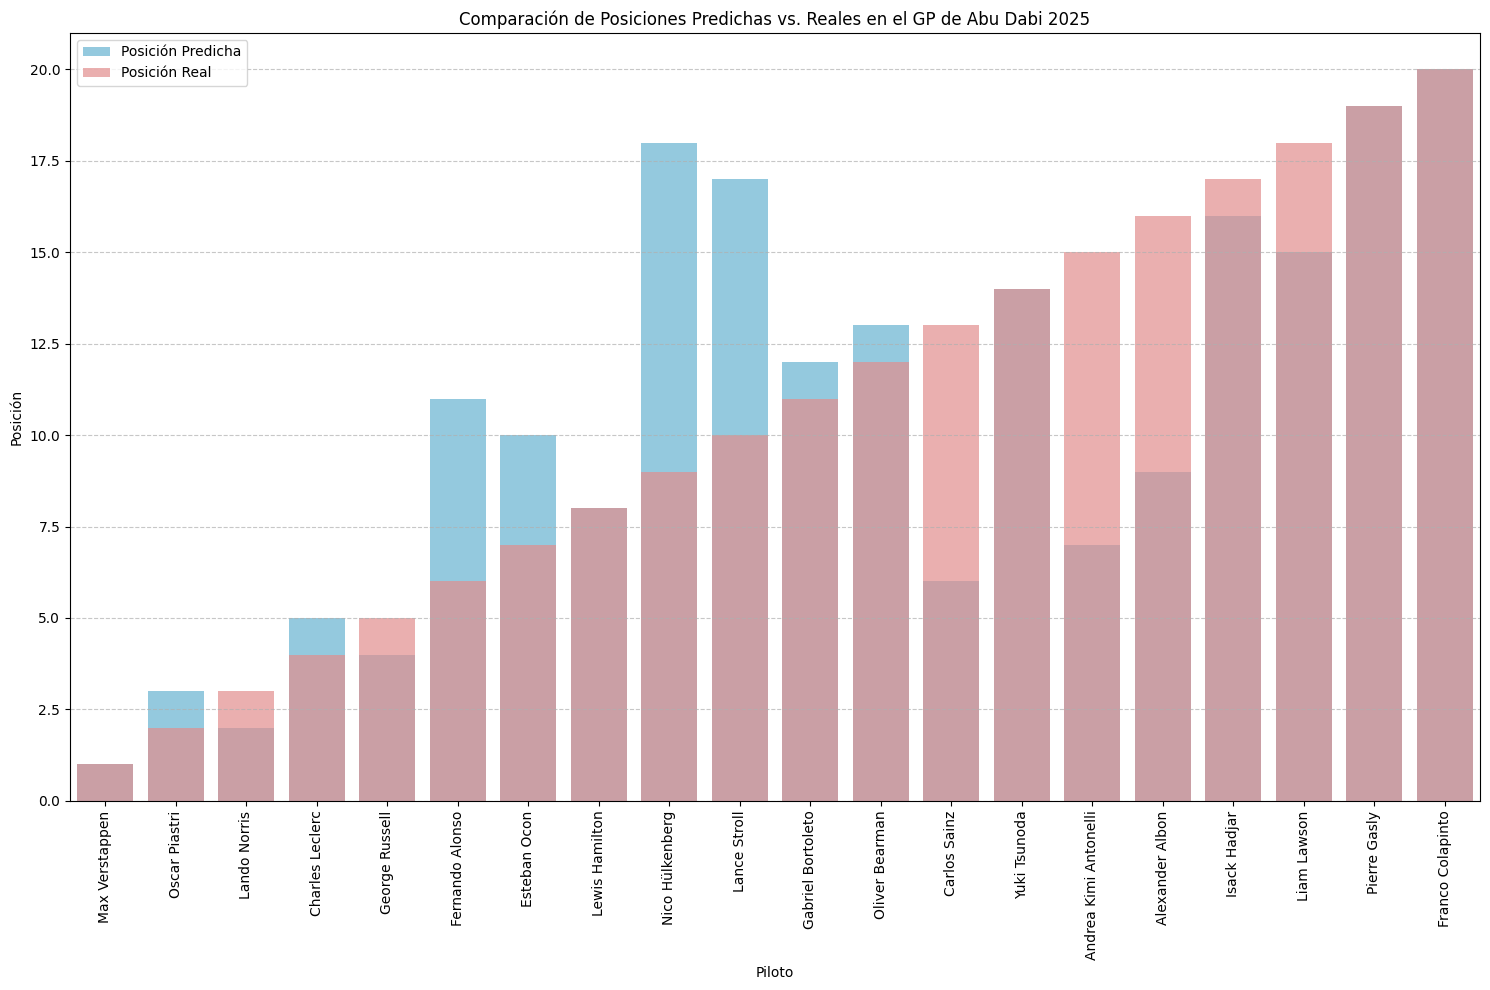

In [ ]:
# Asegurarse de que ambos DataFrames estén ordenados para una comparación significativa
predicted_race_order['Predicted_Position'] = predicted_race_order.index + 1
df_resultados['Actual_Position'] = df_resultados.index + 1

# Unir los DataFrames por el nombre del piloto
comparison_df = pd.merge(predicted_race_order[['DRIVER', 'Predicted_Position']],
                         df_resultados[['Pilotos', 'Actual_Position']],
                         left_on='DRIVER', right_on='Pilotos', how='left')

# Si hay pilotos predichos que no están en los resultados reales o viceversa, se puede manejar aquí
# Por ahora, vamos a enfocarnos en los pilotos que están en ambos
comparison_df = comparison_df.dropna()

# Convertir las posiciones a enteros
comparison_df['Predicted_Position'] = comparison_df['Predicted_Position'].astype(int)
comparison_df['Actual_Position'] = comparison_df['Actual_Position'].astype(int)

# Calcular la diferencia absoluta para ver el error de posición
comparison_df['Position_Difference'] = abs(comparison_df['Predicted_Position'] - comparison_df['Actual_Position'])

# Ordenar por la posición predicha o actual para una mejor visualización
comparison_df = comparison_df.sort_values(by='Actual_Position')

plt.figure(figsize=(15, 10))
sns.barplot(x='DRIVER', y='Predicted_Position', data=comparison_df, color='skyblue', label='Posición Predicha')
sns.barplot(x='DRIVER', y='Actual_Position', data=comparison_df, color='lightcoral', label='Posición Real', alpha=0.7)

plt.ylabel('Posición')
plt.xlabel('Piloto')
plt.title('Comparación de Posiciones Predichas vs. Reales en el GP de Abu Dabi 2025')
plt.xticks(rotation=90)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Análisis de la importancia de los atributos

Top 10 Feature Importances:
                 Feature  Importance
29            RACE VALID    0.463652
8           AVG HUMIDITY    0.329069
3              LAPS RACE    0.109416
2        LAP DISTANCE KM    0.018476
11  AVG SURFACE PRESSURE    0.015518
10      AVG PRESSURE MSL    0.012692
24                BEST Q    0.009424
7        AVG TEMPERATURE    0.008446
21                    Q1    0.007625
9          PRECIPITATION    0.005155


/tmp/ipython-input-2754381873.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')


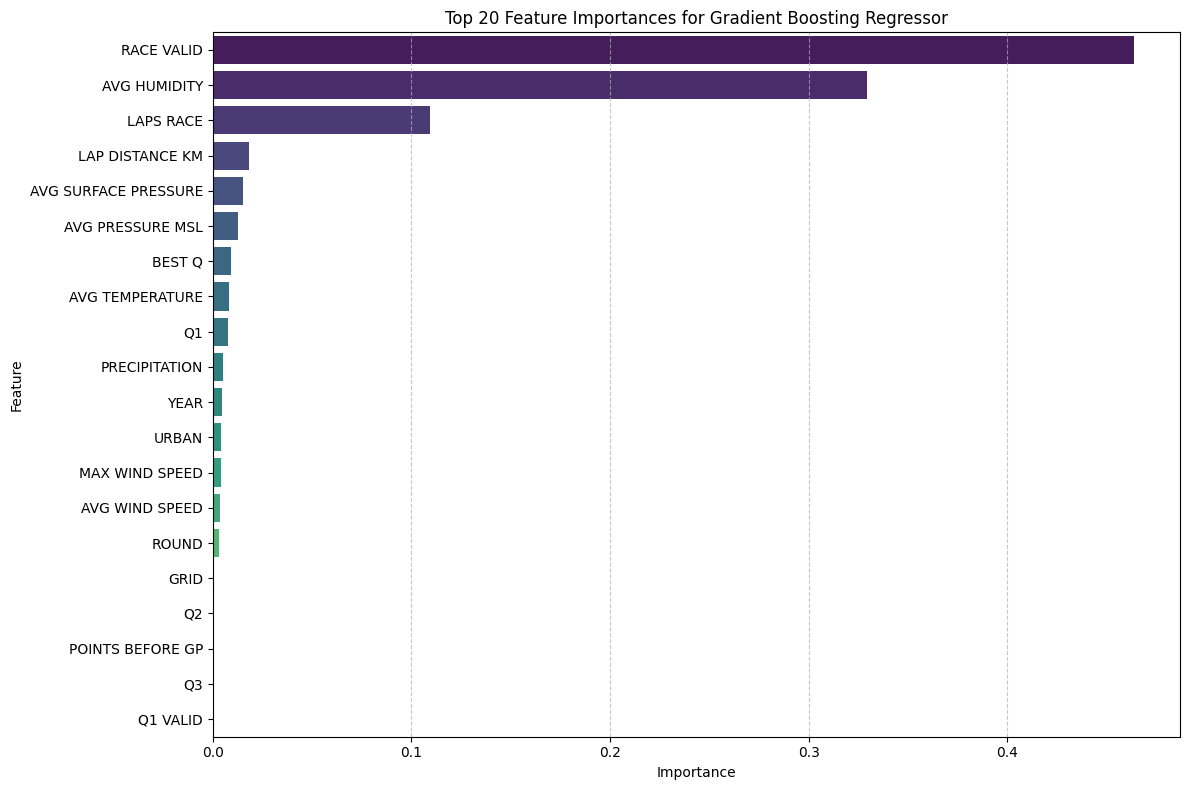

In [ ]:
preprocessor_fitted = final_model.named_steps['preprocessor']

# Get feature names after preprocessing
numerical_feature_names = preprocessor_fitted.named_transformers_['num'].get_feature_names_out(numerical_features)
all_feature_names = list(numerical_feature_names)

# Get feature importances from the trained GradientBoostingRegressor
feature_importances = final_model.named_steps['model'].feature_importances_

# Create a DataFrame for better visualization and sorting
importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Top 10 Feature Importances:")
print(importance_df.head(10))

# Plotting feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')
plt.title('Top 20 Feature Importances for Gradient Boosting Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()